# MODIS Water Random Forest Hyperparameter Tuning

Version: 0.5.0

Date modified: 05.12.2022

Modified by: Caleb Spradlin

In [1]:
import csv
import datetime
import glob
import joblib
import numpy as np
import os
import pandas as pd
from pathlib import Path   
import optuna

from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier as skRF
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, precision_score, f1_score
from sklearn.metrics import classification_report, roc_curve, auc, matthews_corrcoef
from sklearn.model_selection import RandomizedSearchCV, KFold, StratifiedKFold
from sklearn.inspection import permutation_importance

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

#GDAL Stuff
from osgeo import gdalconst
from osgeo import gdal

from pprint import pprint

plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
FIGURE_OUTPUT_DIR = '/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp'
RASTER_OUTPUT_DIR = '/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp'
MODEL_OUTPUT_DIR = '/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/models/'

training_data_basepath = '/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v4.2.0'

qaMaskPath = '/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/qa'
waterMaskPath = '/explore/nobackup/people/mcarrol2/MODIS_water/v5_outputs'

test_data_basepath = '/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/test_data/'

GPU = True
TILE = 'Golden'
MODEL = 'rf'
TEST_RATIO = 0.2
RANDOM_STATE = 42
LABEL_NAME = 'water'
DATA_TYPE = np.int16
# Columns that are offset, years, julian days, etc (always need to be dropped).
offsets_indexes = ['x_offset', 'y_offset', 'year', 'julian_day','tileID']
# Columns that the user wants to drop for training purposes. 
colsToDrop = ['ndvi'] # ['sur_refl_b03_1','sur_refl_b04_1','sur_refl_b05_1','ndwi1','ndwi2']
colsToDropTraining = colsToDrop.copy()
colsToDropTraining.extend(offsets_indexes)
v_names = ['sur_refl_b01_1','sur_refl_b02_1','sur_refl_b03_1',
           'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
           'sur_refl_b07_1','ndvi','ndwi1','ndwi2']

In [3]:
colsToDrop

['ndvi']

In [4]:
colsToDropTraining

['ndvi', 'x_offset', 'y_offset', 'year', 'julian_day', 'tileID']

In [5]:
def load_data(fpath, colsToDrop, yCol='water', testSize=0.2, randomState=42, 
              dataType=np.float32, cpu=True, splitXY=False, trainTestSplit=False,
             applyLog=False, imbalance=False, frac=0.1, land=False, multi=False, 
              multisample=1000000):
    """
    Simple helper function for loading data to be used by models
    :param fpath: Path to the data to be ingested.
    :param dataType: Data type to convert ingested data to.
    :param colsToDrop: Columns which are not necessary, from which to drop.
    :param testSize: Ration to
    """
    if multi:
        all_dfs = [pd.read_csv(path_) for path_ in fpath]
        df = pd.concat(all_dfs).sample(n=multisample, random_state=randomState)
        print('DF length: {}'.format(len(df.index)))
    else:   
        df = pd.read_parquet(fpath) if '.parquet' in fpath else pd.read_csv(fpath)
    df = df[df['sur_refl_b01_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b07_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b06_1'] + df['sur_refl_b02_1'] != 0]
    df = df.drop(columns=colsToDrop)
    cleanedDF = df[~df.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0).astype(dataType)
    if applyLog:
        for col in cleanedDF.drop([yCol], axis=1).columns:
            print('Applying log1p func to {}'.format(col))
            cleanedDF[col] = np.log1p(cleanedDF[col])
        cleanedDF = cleanedDF[~cleanedDF.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0)
    df = None
    if imbalance:
        if land:
            print('Imbalancing data, sampling {} from water'.format(frac))
        else:
            print(f'Imbalancing data, sampling {frac} from land, {1-frac} from water')
        groupedDF = cleanedDF.groupby('water')
        dfs = [groupedDF.get_group(y) for y in groupedDF.groups]
        sampledDF = dfs[1].sample(frac=frac)if land else dfs[0].sample(frac=frac)
        concatDF = sampledDF.append(dfs[0]) if land else sampledDF.append(dfs[1])
        concatDF = concatDF.sample(frac=1)
        concatDF = concatDF.reset_index()
        cleanedDF = concatDF.drop(columns=['index'])
    if not splitXY:
        return cleanedDF
    X = cleanedDF.drop([yCol], axis=1).astype(dataType)
    y = cleanedDF[yCol].astype(dataType)
    if trainTestSplit:
        return train_test_split(X, y, test_size=TEST_RATIO)
    else:
        return X, y

## Data 
- Read in to cuDF or pandas Dataframe
- Drop unnecessary columns
- Clean data
- Split into Xs and Ys
- Train-test split

In [6]:
glob_string = os.path.join(training_data_basepath,'MOD*{}*.parquet.gzip'.format(TILE))
data_paths = sorted([fv for fv in glob.glob(glob_string)])

#Only want the one with 4.2.0 because the other file doesnt work. 
print(data_paths)
data_path = data_paths[0]
print(data_path)

['/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v4.2.0/MOD09_Golden_Masked_1007000_4_2_0.parquet.gzip', '/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v4.2.0/MOD09_Golden_Masked_1007000_4_2_2.parquet.gzip']
/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v4.2.0/MOD09_Golden_Masked_1007000_4_2_0.parquet.gzip


In [7]:
X, X_test, y, y_test = load_data(fpath=data_path,
                                colsToDrop=colsToDropTraining,
                                dataType=DATA_TYPE,
                                cpu=True,
                                splitXY=True,
                                imbalance=True,
                                frac=0.45,
                                trainTestSplit=True
                                )

Imbalancing data, sampling 0.45 from land, 0.55 from water


In [8]:
_ = [print(column) for column in X.columns]

sur_refl_b01_1
sur_refl_b02_1
sur_refl_b03_1
sur_refl_b04_1
sur_refl_b05_1
sur_refl_b06_1
sur_refl_b07_1
ndwi1
ndwi2


In [9]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
sur_refl_b01_1,553920.0,1184.200227,1973.249853,-100.0,41.0,541.0,1252.0,16000.0
sur_refl_b02_1,553920.0,1546.747391,1901.495393,-100.0,2.0,1121.0,2421.0,16000.0
sur_refl_b03_1,553920.0,988.030145,1927.357508,-100.0,190.0,299.0,657.0,13347.0
sur_refl_b04_1,553920.0,1146.141822,1935.824856,-100.0,140.0,544.0,980.0,16000.0
sur_refl_b05_1,553920.0,1428.442414,1891.219407,-28672.0,35.0,860.0,2801.0,14954.0
sur_refl_b06_1,553920.0,1178.053083,1305.682962,-100.0,62.0,502.0,2208.0,10993.0
sur_refl_b07_1,553920.0,-78.935272,5079.590288,-28672.0,29.0,226.0,1361.0,7247.0
ndwi1,553920.0,-2558.577585,6867.462041,-32758.0,-9298.0,-1373.0,1763.0,32762.0
ndwi2,553920.0,-803.049036,8410.635300,-32745.0,-8421.0,574.0,5255.0,32762.0


In [10]:
def output_interesting_idx(df, column, threshold, greaterThan=True):
    dfToReturn = df[df[column] > threshold] if \
        greaterThan else df[df[column] < threshold]
    return dfToReturn

In [11]:
# ndviOverTenK = output_interesting_idx(X, 'ndvi', 10000)
# ndviOverTenK

In [12]:
# output_interesting_idx(X, 'ndwi1', 10000)

In [13]:
# output_interesting_idx(X, 'ndwi2', 10000)

# Model definition and training

Set TREES_AND_DEPTH_ONLY to True if you only want to tune number of estimators and max_depth.

In [14]:
TREES_AND_DEPTH_ONLY = False

In [15]:
def objective(trial):
    list_trees = [75, 100, 125, 150, 175, 200, 250, 300, 400, 500]
    max_depth = [5, 10, 30, 50, 80, 90, 100, 110]
    min_samples_leaf = [1, 2, 3, 4, 5]
    min_samples_split = [2, 4, 8, 10]
    bootstrap = [True, False]
    max_features = ['auto', 'sqrt', 'log2']
    
    # if TREES_AND_DEPTH_ONLY:
    #     param = {'n_estimators': trial.suggest_categorical('n_estimators', list_trees), 
    #                'criterion':'gini', 
    #                'max_depth':trial.suggest_categorical('max_depth', max_depth), 
    #                'min_samples_split':2, 
    #                'min_samples_leaf':1, 
    #                'min_weight_fraction_leaf':0.0, 
    #                'max_features':'auto', 
    #                'max_leaf_nodes':None, 
    #                'min_impurity_decrease':0.0, 
    #                'bootstrap':True, 
    #                'oob_score':False, 
    #                'n_jobs':-1, 
    #                # 'random_state':42, 
    #                'verbose':0, 
    #                'warm_start':True, 
    #                'class_weight':None, 
    #                'ccp_alpha':0.0, 
    #                'max_samples':None
    #                   }
    # else:
    param = {'n_estimators': trial.suggest_categorical('n_estimators', list_trees), 
                       'max_depth':trial.suggest_categorical('max_depth', max_depth), 
                       'min_samples_split':trial.suggest_categorical('min_samples_split', min_samples_split), 
                       'min_samples_leaf':trial.suggest_categorical('min_samples_leaf', min_samples_leaf), 
                       'bootstrap': trial.suggest_categorical('bootstrap', bootstrap),
                       'criterion':'gini', 
                       #'min_weight_fraction_leaf': trial.suggest_float('min_weight_fraction_leaf', 1e-8, 1.0, log=True), 
                       'max_features':trial.suggest_categorical('max_features', max_features), 
                       'max_leaf_nodes':None, 
                       'min_impurity_decrease':0.0, 
                       'oob_score':False, 
                       'n_jobs':-1, 
                       # 'random_state':42, 
                       'verbose':0, 
                       'warm_start':False, 
                       'class_weight':None, 
                       'ccp_alpha':0.0, 
                       'max_samples':None
                      }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    cv_scores = np.empty(5)
    for idx, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = skRF(**param)
        model.fit(X_train, 
                  y_train)
        preds = model.predict(X_val)
        cv_scores[idx] = f1_score(y_val, preds)
        if cv_scores[idx] == 0.0:
            print('Pruning because of 0.0 score.')
            return 0.0
        print('Fold {}: {}'.format(idx, cv_scores[idx]))
    return np.mean(cv_scores)

### Start hyperparameter tuning trials.

Ex output: Trial 0 finished with values: [0.9527224325581133, 0.9667626330841518, 9684.0] and parameters:

The metrics in order are: [precision, f1, false positives]

If you want to only exhaust the search space above, set `GRID_SEARCH = True`.

In [17]:
GRID_SEARCH = True

In [18]:
%%time

optuna.logging.set_verbosity(optuna.logging.INFO)
if GRID_SEARCH:
    study = optuna.create_study(study_name='RF Tuning Grid Search', 
                                direction='maximize',
                                sampler=optuna.samplers.GridSampler(search_space))
    
else:
    study = optuna.create_study(study_name='RF Tuning',
                                direction='maximize')
study.optimize(objective, n_trials=25, timeout=30*60)

[I 2023-02-28 21:33:39,959] A new study created in memory with name: RF Tuning Grid Search


Fold 0: 0.985898883272092
Fold 1: 0.9855793781511397
Fold 2: 0.9850823637829742
Fold 3: 0.9855387360423622


[I 2023-02-28 21:34:16,367] Trial 0 finished with value: 0.9856933516209592 and parameters: {'n_estimators': 125, 'max_depth': 110, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9856933516209592.


Fold 4: 0.9863673968562282
Fold 0: 0.9843612873523531
Fold 1: 0.9838503058654192
Fold 2: 0.9834847055264656
Fold 3: 0.9839110247273511


[I 2023-02-28 21:34:43,447] Trial 1 finished with value: 0.9841075610125769 and parameters: {'n_estimators': 125, 'max_depth': 50, 'min_samples_split': 4, 'min_samples_leaf': 5, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9856933516209592.


Fold 4: 0.984930481591295
Fold 0: 0.9707800603361585
Fold 1: 0.970754859231283
Fold 2: 0.9691809121415279
Fold 3: 0.9696412143514259


[I 2023-02-28 21:35:09,028] Trial 2 finished with value: 0.9703105654187454 and parameters: {'n_estimators': 250, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 4, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9856933516209592.


Fold 4: 0.9711957810333307
Fold 0: 0.985311888594775
Fold 1: 0.98494877403016
Fold 2: 0.9841825489433423
Fold 3: 0.984643062751871


[I 2023-02-28 21:35:37,179] Trial 3 finished with value: 0.984947859825752 and parameters: {'n_estimators': 100, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 5, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 0 with value: 0.9856933516209592.


Fold 4: 0.9856530248086111
Fold 0: 0.9856168915225958
Fold 1: 0.9850014027465057
Fold 2: 0.9843860280878646
Fold 3: 0.9846703035711715


[I 2023-02-28 21:35:58,129] Trial 4 finished with value: 0.9850712037868652 and parameters: {'n_estimators': 75, 'max_depth': 100, 'min_samples_split': 8, 'min_samples_leaf': 4, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 0 with value: 0.9856933516209592.


Fold 4: 0.9856813930061878
Fold 0: 0.9794593037906333
Fold 1: 0.9794402211472011
Fold 2: 0.978878263564104
Fold 3: 0.9792262629610682


[I 2023-02-28 21:36:18,421] Trial 5 finished with value: 0.9794916120095373 and parameters: {'n_estimators': 125, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 3, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9856933516209592.


Fold 4: 0.98045400858468
Fold 0: 0.9856598345918733
Fold 1: 0.9853408714916634
Fold 2: 0.9847793217654258
Fold 3: 0.9854135933508438


[I 2023-02-28 21:36:59,595] Trial 6 finished with value: 0.9854839033033223 and parameters: {'n_estimators': 150, 'max_depth': 110, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9856933516209592.


Fold 4: 0.9862258953168044
Fold 0: 0.985118426825672
Fold 1: 0.9847329342695982
Fold 2: 0.9840549649987036
Fold 3: 0.9843460987599231


[I 2023-02-28 21:37:31,140] Trial 7 finished with value: 0.9847265336073721 and parameters: {'n_estimators': 150, 'max_depth': 100, 'min_samples_split': 8, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9856933516209592.


Fold 4: 0.9853802431829629
Fold 0: 0.9857404810700032
Fold 1: 0.9853633977056137
Fold 2: 0.9847571732008497
Fold 3: 0.9852503129811636


[I 2023-02-28 21:38:18,771] Trial 8 finished with value: 0.9854527478392022 and parameters: {'n_estimators': 175, 'max_depth': 110, 'min_samples_split': 8, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9856933516209592.


Fold 4: 0.9861523742383805
Fold 0: 0.9849473192132043
Fold 1: 0.9845511782694729
Fold 2: 0.9838450624086198
Fold 3: 0.9842524218738754


[I 2023-02-28 21:38:41,355] Trial 9 finished with value: 0.9845847711851938 and parameters: {'n_estimators': 100, 'max_depth': 80, 'min_samples_split': 10, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'auto'}. Best is trial 0 with value: 0.9856933516209592.


Fold 4: 0.985327874160796
Fold 0: 0.9853417149761928
Fold 1: 0.9849135605292123
Fold 2: 0.9842986992408637
Fold 3: 0.9846490438938027


[I 2023-02-28 21:39:16,629] Trial 10 finished with value: 0.9849655353767897 and parameters: {'n_estimators': 125, 'max_depth': 110, 'min_samples_split': 4, 'min_samples_leaf': 5, 'bootstrap': False, 'max_features': 'auto'}. Best is trial 0 with value: 0.9856933516209592.


Fold 4: 0.9856246582438771
Fold 0: 0.9856954842607176
Fold 1: 0.9850797807288894
Fold 2: 0.9846371028730706
Fold 3: 0.9852273463190692


[I 2023-02-28 21:40:57,727] Trial 11 finished with value: 0.9853324403868676 and parameters: {'n_estimators': 400, 'max_depth': 30, 'min_samples_split': 10, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'auto'}. Best is trial 0 with value: 0.9856933516209592.


Fold 4: 0.9860224877525914
Fold 0: 0.9705358425513576
Fold 1: 0.9708220525820653
Fold 2: 0.9698071451153967
Fold 3: 0.9702480645787358


[I 2023-02-28 21:41:24,084] Trial 12 finished with value: 0.9704875395283079 and parameters: {'n_estimators': 300, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 4, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9856933516209592.


Fold 4: 0.971024592813984
Fold 0: 0.9844453717426652
Fold 1: 0.983967993552658
Fold 2: 0.9834976842014276
Fold 3: 0.9838296279230504


[I 2023-02-28 21:42:03,804] Trial 13 finished with value: 0.9840817106761517 and parameters: {'n_estimators': 200, 'max_depth': 90, 'min_samples_split': 8, 'min_samples_leaf': 5, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9856933516209592.


Fold 4: 0.9846678759609571
Fold 0: 0.9855733271963639
Fold 1: 0.9848194886110191
Fold 2: 0.9842922887453277
Fold 3: 0.9850387524377694


[I 2023-02-28 21:42:55,001] Trial 14 finished with value: 0.9851072796717153 and parameters: {'n_estimators': 200, 'max_depth': 30, 'min_samples_split': 10, 'min_samples_leaf': 4, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9856933516209592.


Fold 4: 0.9858125413680969
Fold 0: 0.9707990405193835
Fold 1: 0.9709466061267888
Fold 2: 0.9694896742020321
Fold 3: 0.9694185645272603


[I 2023-02-28 21:43:11,397] Trial 15 finished with value: 0.9703173916329826 and parameters: {'n_estimators': 175, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9856933516209592.


Fold 4: 0.970933072789448
Fold 0: 0.9859928670041417
Fold 1: 0.9856077334158078
Fold 2: 0.985200115174201
Fold 3: 0.985640700987022


[I 2023-02-28 21:45:18,171] Trial 16 finished with value: 0.9857678701471905 and parameters: {'n_estimators': 500, 'max_depth': 90, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'auto'}. Best is trial 16 with value: 0.9857678701471905.


Fold 4: 0.98639793415478
Fold 0: 0.9856231525499306
Fold 1: 0.9851242285171703
Fold 2: 0.9843499052928
Fold 3: 0.9849902141376927


[I 2023-02-28 21:46:05,363] Trial 17 finished with value: 0.9851800492009446 and parameters: {'n_estimators': 175, 'max_depth': 80, 'min_samples_split': 2, 'min_samples_leaf': 4, 'bootstrap': False, 'max_features': 'auto'}. Best is trial 16 with value: 0.9857678701471905.


Fold 4: 0.9858127455071296
Fold 0: 0.9858207023497944
Fold 1: 0.9852410201821137
Fold 2: 0.9848351743306882
Fold 3: 0.9852922129319153


[I 2023-02-28 21:46:57,851] Trial 18 finished with value: 0.9854798462008907 and parameters: {'n_estimators': 200, 'max_depth': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 16 with value: 0.9857678701471905.


Fold 4: 0.9862101212099413
Fold 0: 0.9844655024787561
Fold 1: 0.9841742772632079
Fold 2: 0.9835241230755931
Fold 3: 0.9838022288133152


[I 2023-02-28 21:48:30,289] Trial 19 finished with value: 0.9841517350886345 and parameters: {'n_estimators': 500, 'max_depth': 30, 'min_samples_split': 8, 'min_samples_leaf': 5, 'bootstrap': True, 'max_features': 'auto'}. Best is trial 16 with value: 0.9857678701471905.


Fold 4: 0.9847925438122999
Fold 0: 0.9847233809948501
Fold 1: 0.9842037464827249
Fold 2: 0.9837052831765332
Fold 3: 0.9839560645212371


[I 2023-02-28 21:48:57,053] Trial 20 finished with value: 0.9843257469588241 and parameters: {'n_estimators': 125, 'max_depth': 100, 'min_samples_split': 10, 'min_samples_leaf': 3, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 16 with value: 0.9857678701471905.


Fold 4: 0.985040259618775
Fold 0: 0.9704800758468124
Fold 1: 0.9708180147058825
Fold 2: 0.9694586804482365
Fold 3: 0.9695797811929442


[I 2023-02-28 21:49:23,373] Trial 21 finished with value: 0.9702753525098562 and parameters: {'n_estimators': 300, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 5, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 16 with value: 0.9857678701471905.


Fold 4: 0.9710402103554058
Fold 0: 0.9853588379116927
Fold 1: 0.9849805783340526
Fold 2: 0.9844303615151951
Fold 3: 0.9848080313770645


[I 2023-02-28 21:50:39,958] Trial 22 finished with value: 0.9850437020250054 and parameters: {'n_estimators': 400, 'max_depth': 110, 'min_samples_split': 8, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'auto'}. Best is trial 16 with value: 0.9857678701471905.


Fold 4: 0.985640700987022
Fold 0: 0.9846344200500676
Fold 1: 0.9841907187933999
Fold 2: 0.983759803533233
Fold 3: 0.9839331989634321


[I 2023-02-28 21:51:01,776] Trial 23 finished with value: 0.9843000807142556 and parameters: {'n_estimators': 100, 'max_depth': 90, 'min_samples_split': 4, 'min_samples_leaf': 4, 'bootstrap': True, 'max_features': 'auto'}. Best is trial 16 with value: 0.9857678701471905.


Fold 4: 0.984982262231145
Fold 0: 0.9853421366820582
Fold 1: 0.984774130412883
Fold 2: 0.9842477149463038
Fold 3: 0.9846997524324946


[I 2023-02-28 21:51:30,328] Trial 24 finished with value: 0.9849317982826975 and parameters: {'n_estimators': 100, 'max_depth': 80, 'min_samples_split': 10, 'min_samples_leaf': 5, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 16 with value: 0.9857678701471905.


Fold 4: 0.9855952569397476
CPU times: user 10h 27min 11s, sys: 1min 43s, total: 10h 28min 55s
Wall time: 17min 50s


## Get metrics from the overall hyperparameter tuning

In [19]:
print("Number of finished trials: {}".format(len(study.trials)))
trials = study.best_trials
trial_score = max([trial.values[0] for trial in trials])
best_trial_params = [trial.params for trial in trials if trial.values[0] == trial_score][0]
print(best_trial_params)
print(trial_score)

trial_scores = [trial.values for trial in trials]
trial_params = [trial.params for trial in trials]

for score, param in zip(trial_scores, trial_params):
    print(score)
    for k, v in param.items():
        print("     {}: {}".format(k, v))

study_df = study.trials_dataframe()
study_df.to_csv("hyperopt_tuning_trial_{}_rf.csv".format(
    datetime.datetime.now().strftime('%Y_%m_%d_%H_%M')))

Number of finished trials: 25
{'n_estimators': 500, 'max_depth': 90, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'auto'}
0.9857678701471905
[0.9857678701471905]
     n_estimators: 500
     max_depth: 90
     min_samples_split: 4
     min_samples_leaf: 1
     bootstrap: False
     max_features: auto


### Visualize the optimization history

<AxesSubplot: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

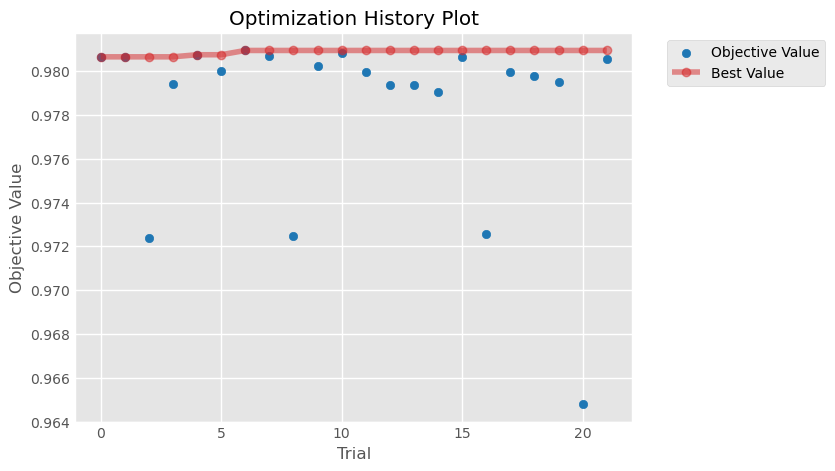

In [43]:
optuna.visualization.matplotlib.plot_optimization_history(study)

### Visualize hyperparameter importances

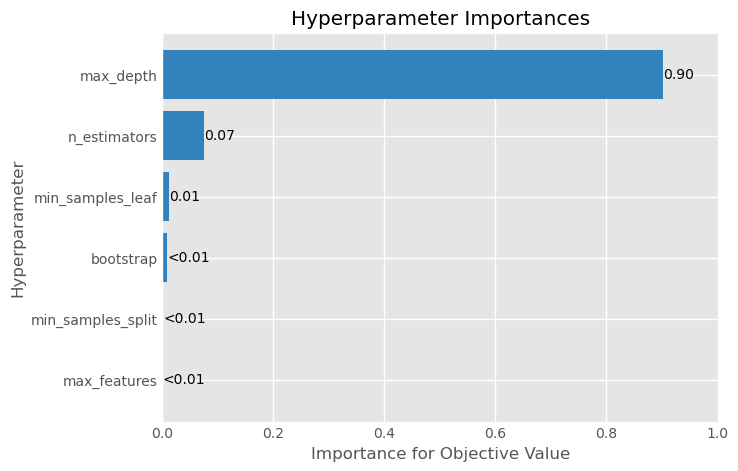

In [20]:
try:
    optuna.visualization.matplotlib.plot_param_importances(study)
except:
    print('Tuning only one hyper-parameter')

## Training the model with the best hyperparamers

In [44]:
hyperparameters = best_trial_params
hyperparameters['n_jobs'] = -1
print('Using these params:')
pprint(hyperparameters)
classifier = skRF(**hyperparameters)

Using these params:
{'bootstrap': False,
 'max_depth': 50,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300,
 'n_jobs': -1}


In [45]:
classifier.fit(X, y)

RandomForestClassifier(bootstrap=False, max_depth=50, max_features='auto',
                       n_estimators=300, n_jobs=-1)

## Model testing and training/testing data validation

### Get model metrics

In [33]:
score = classifier.score(X_test, y_test)
score = round(score, 3)
score

0.981

In [34]:
train_predictions = classifier.predict(X)
test_predictions = classifier.predict(X_test)
prediction_probs = classifier.predict_proba(X_test)

In [35]:
test_predictions = test_predictions.astype(np.int16)
y_test_int = y_test.astype(np.int16)

In [36]:
print('Test Performance')
print('-------------------------------------------------------')
print(classification_report(y_test, test_predictions))
# From docs: tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
tn, fp, fn, tp = confusion_matrix(y_test_int, test_predictions).ravel()
recall = (tp / (tp + fp))
print('Test Recall')
print('-------------------------------------------------------')
print(recall)
print('\nTest Matthews Correlation Coefficient (MCC)')
print('-------------------------------------------------------')
mcc = matthews_corrcoef(y_test_int, test_predictions)
print(mcc)
print('\nConfusion Matrix')
print('-------------------------------------------------------')
print('TP: {:9} FN: {:9}'.format(tp, fn))
print('FP: {:9} TN: {:9}'.format(fp, tn))

Test Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    583068
           1       0.98      0.98      0.98    511191

    accuracy                           0.98   1094259
   macro avg       0.98      0.98      0.98   1094259
weighted avg       0.98      0.98      0.98   1094259

Test Recall
-------------------------------------------------------
0.9826021641114578

Test Matthews Correlation Coefficient (MCC)
-------------------------------------------------------
0.9627028111002978

Confusion Matrix
-------------------------------------------------------
TP:    499721 FN:     11470
FP:      8848 TN:    574220


## NDVI Over 10,000

In [38]:
ndviOver10Predictions = classifier.predict(ndviOverTenK)
withPrediction = ndviOverTenK.assign(water_prediction=ndviOver10Predictions)
print('Number of rows: {}'.format(len(ndviOverTenK.index)))
print('Number of water predictions: {}'.format(np.count_nonzero(ndviOver10Predictions == 1)))
print('Number of land predictions: {}'.format(np.count_nonzero(ndviOver10Predictions == 0)))
withPrediction

Number of rows: 30873
Number of water predictions: 30413
Number of land predictions: 460


,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b03_1,sur_refl_b04_1,sur_refl_b05_1,sur_refl_b06_1,sur_refl_b07_1,ndvi,ndwi1,ndwi2,water_prediction
90272,9,-5,22,110,7,23,15,30536,-15555,-20000,1
3451965,2,-7,130,72,25,42,39,18000,-14000,-14375,1
2948266,-1,2,45,23,8,7,15,30000,-5555,-7647,1
5368680,12,-27,106,70,5,47,15,26000,28536,-30536,1
1688176,10,-27,206,138,-21,384,288,21764,-11512,-12068,1
...,...,...,...,...,...,...,...,...,...,...,...
3089571,1,-18,111,110,20,26,11,11176,10536,-24108,1
1443873,1,-2,79,36,-17,27,4,30000,-11600,-30000,1
5078032,6,-4,85,58,-3,51,25,15536,-11702,-13809,1
377138,18,-12,214,114,5,70,30,15536,-14137,-23333,1


In [39]:
withPrediction[withPrediction['water_prediction'] == 0]

,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b03_1,sur_refl_b04_1,sur_refl_b05_1,sur_refl_b06_1,sur_refl_b07_1,ndvi,ndwi1,ndwi2,water_prediction
2180432,-100,2775,-100,-100,2409,1075,271,10747,4415,8220,0
3573079,-10,1658,-40,194,1918,1000,412,10121,2475,6019,0
4982884,-100,3024,-81,370,3091,1870,780,10683,2357,5899,0
1588307,-16,727,-100,251,2573,1929,1069,10450,-4525,-1904,0
3308235,-35,3217,-100,98,2915,1276,309,10219,4320,8247,0
...,...,...,...,...,...,...,...,...,...,...,...
2300158,-100,1107,-100,-100,2006,2171,1698,11986,-3245,-2106,0
4375749,-10,579,-100,35,1175,743,217,10351,-1240,4547,0
5070018,-84,581,184,468,1653,1284,824,13380,-3769,-1729,0
934282,-100,420,-100,-100,1110,748,286,16250,-2808,1898,0


### Permutation importance

In [40]:
permutation_importance_results = permutation_importance(classifier,
                                                        X=X_test,
                                                        y=y_test,
                                                        n_repeats=5,
                                                        random_state=42)

Text(0.5, 0, 'Permutation Importance')

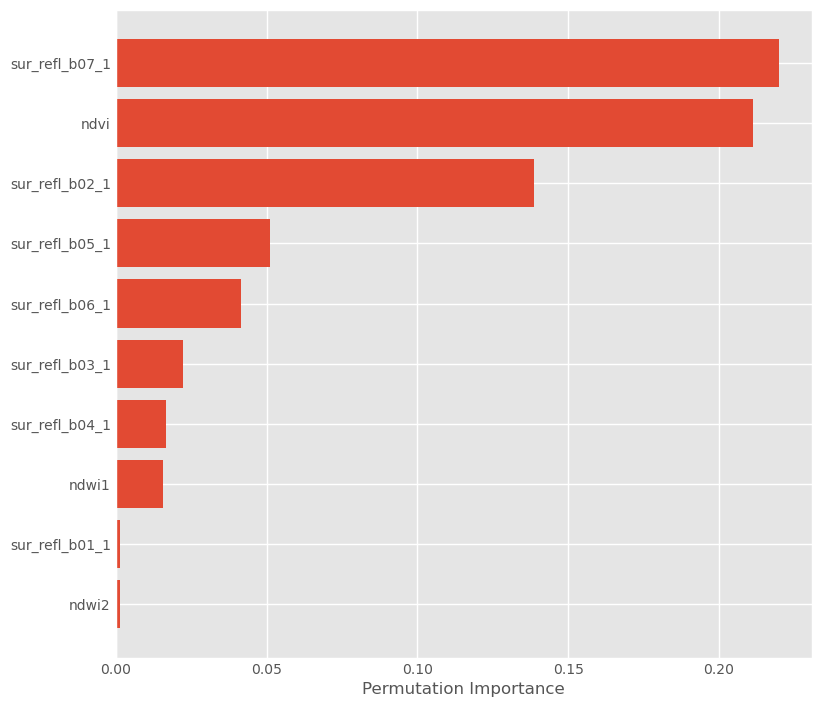

In [41]:
png_save_path = 'mw_{}_{}_{}_{}_{}_permutation_importance.png'.format(
    TILE,
    score,
    MODEL,
    hyperparameters['n_estimators'],
    datetime.datetime.now().strftime('%Y_%m_%d_%H_%M'))

png_save_path = os.path.join(FIGURE_OUTPUT_DIR, png_save_path)

sorted_idx = permutation_importance_results.importances_mean.argsort()
plt.figure(figsize=(8, 8))
plt.barh(X_test.columns[sorted_idx], permutation_importance_results.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

Garbage collection

## Save the model for future use

In [43]:
model_save_path = 'mw_{}_{}_{}_{}_4.1.0_tuned_{}.sav'.format(TILE,
                                                              score,
                                                              hyperparameters['n_estimators'],
                                                              MODEL,
                                                              'cpu',
                                                              datetime.datetime.now().strftime('%Y_%m_%d_%H_%M'))
model_save_path = os.path.join(MODEL_OUTPUT_DIR, model_save_path)
print('Saving model to: {}'.format(model_save_path))
print(classifier)
joblib.dump(classifier, model_save_path, compress=3)

Saving model to: /explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/models/mw_Golden_0.981_200_rf_4.1.0_tuned_cpu.sav
RandomForestClassifier(max_depth=50, n_estimators=200, n_jobs=-1)


['/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/models/mw_Golden_0.981_200_rf_4.1.0_tuned_cpu.sav']

In [44]:
classifier = classifier # joblib.load('/adapt/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/models/mw_h11v10_0.983_500_rf_4.2.0_tuned_cpu.sav')

# Testing: raster testing

In [46]:
import sys
sys.path.append('../../..')
from modis_water_training.model.TabularModisDataGenerator import TabularModisDataGenerator

In [47]:
TILE = 'h11v10'
DAY = 201
YEAR = 2006

In [48]:
tabularGen = TabularModisDataGenerator(tile=TILE, year=YEAR, julianDays=[DAY])
sensorDir = f'/css/modis/Collection6.1/L2G/MOD09GA/{YEAR}'
modisFilesDict = tabularGen._readFiles(julianDay=DAY, sensorDir=sensorDir)
modisFilesList = list(modisFilesDict.values())
qa_mask, qa_mask_path = tabularGen._generateBadDataMask(day=DAY, files=modisFilesDict)

/css/modis/Collection6.1/L2G/MOD09GA/2006/*GA.A2006201.h11v10*.hdf
/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf
Julian day: 201
Files: {'SensorZenith_1': 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_1km_2D:SensorZenith_1', 'SolarZenith_1': 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_1km_2D:SolarZenith_1', 'state_1km_1': 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_1km_2D:state_1km_1', 'sur_refl_b03_1': 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_500m_2D:sur_refl_b03_1', 'sur_refl_b04_1': 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_500m_2D:sur_refl_b04_1', 'sur_refl_b05_1':

In [49]:
vars_list_gq = [fn for fn in modisFilesList
            if 'sur_refl' in fn and 'GQ' in fn]
vars_list_gq.sort()

vars_list_ga = [fn for fn in modisFilesList
            if 'sur_refl' in fn and 'GQ' not in fn]
vars_list_ga.sort()

vars_list = vars_list_gq
vars_list.extend(vars_list_ga)

vars_list

['HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GQ/2006/MOD09GQ.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_2D:sur_refl_b01_1',
 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GQ/2006/MOD09GQ.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_2D:sur_refl_b02_1',
 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_500m_2D:sur_refl_b03_1',
 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_500m_2D:sur_refl_b04_1',
 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_500m_2D:sur_refl_b05_1',
 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_500m_2D:sur_refl_b06_1',
 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_500m_2D:sur_r

### Read in data 
We don't need to slice because we have more than enough GPU memory.

In [50]:
def readRasterToArray(vars_list):
    vrt_options = gdal.BuildVRTOptions(xRes=231.656358, yRes=231.656358, separate=True)
    dd = gdal.BuildVRT('tmp.vrt', vars_list, options=vrt_options)
    nrows, ncols = dd.RasterYSize, dd.RasterXSize
    newshp = (ncols*nrows, dd.RasterCount+3)
    img = np.empty(newshp, dtype=np.int16)
    for b in range(len(vars_list)):
        img[:, b] = dd.GetRasterBand(b+1).ReadAsArray().astype(np.int16).ravel()
    dd = None
    img[:, len(vars_list)] = ((img[:, 1] - img[:, 0]) / (img[:, 1] + img[:, 0])) * 10000
    img[:, len(vars_list)+1] = ((img[:, 1] - img[:, 5]) / (img[:, 1] + img[:, 5])) * 10000
    img[:, len(vars_list)+2] = ((img[:, 1] - img[:, 6]) / (img[:, 1] + img[:, 6])) * 10000
    if os.path.exists('tmp.vrt'):
        os.remove('tmp.vrt')
    return img

In [51]:
im = readRasterToArray(vars_list)
print('Raster as ndarray')
print(im)
print('{} MB size'.format((im.size * im.itemsize) / 1000000))

Raster as ndarray
[[ 282 2985  173 ... 8273 2822 6797]
 [ 289 3045  173 ... 8266 2913 6851]
 [ 275 3198  180 ... 8416 3050 6898]
 ...
 [ 317 1559  144 ... 6620  562 4395]
 [ 252 1447  126 ... 7033  770 4863]
 [ 252 1447  126 ... 7033  770 4863]]
460.8 MB size


In [52]:
def predictRaster(img_chunk, colsToDrop=None):
    """
    Function given a raster in the form of a nxn matrix, will
    convert the matrix to a GPU/CPU-bound data frame then perform 
    predictions given the loaded model.
    
    Return the prediction matrix, the prediction probabilities
    for each and the dataframe converted to host.
    """
    df = pd.DataFrame(img_chunk, columns=v_names, dtype=np.int16)
    df = df.drop(columns=colsToDrop) if colsToDrop else df
    print('Making predictions from raster')
    predictions = classifier.predict(df).astype(np.int16)
    predictionsProbs = classifier.predict_proba(df).astype(np.float32)
    return predictions, predictionsProbs, df

In [53]:
%%time
predictedRaster, predictedProbaRaster, df = predictRaster(im, colsToDrop=colsToDrop)

Making predictions from raster
CPU times: user 31min 40s, sys: 1min 33s, total: 33min 14s
Wall time: 59 s


## Raster as a DataFrame: description and histogram

In [53]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
sur_refl_b01_1,23040000.0,1140.560665,1527.279099,-28672.0,227.0,463.0,1397.0,11069.0
sur_refl_b02_1,23040000.0,2658.499274,1132.979425,-28672.0,2082.0,2533.0,2899.0,10802.0
sur_refl_b03_1,23040000.0,829.334512,1460.147104,-28672.0,152.0,242.0,685.0,9552.0
sur_refl_b04_1,23040000.0,1086.797176,1447.336811,-28672.0,356.0,496.0,1055.0,10207.0
sur_refl_b05_1,23040000.0,2919.611193,1008.000270,-28672.0,2444.0,2757.0,3154.0,8725.0
sur_refl_b06_1,23040000.0,2214.756003,1198.891539,-28672.0,1332.0,1835.0,2798.0,7891.0
sur_refl_b07_1,23040000.0,1316.849571,1626.572310,-28672.0,431.0,873.0,2086.0,8951.0
ndvi,23040000.0,5099.909421,3622.130717,-32758.0,1772.0,6266.0,8435.0,32762.0
ndwi1,23040000.0,1035.434987,2495.314006,-32758.0,-812.0,825.0,3330.0,32762.0
ndwi2,23040000.0,3787.883306,3553.893702,-32758.0,542.0,4209.0,7222.0,32762.0


#### Reshape the unravelled matrix back to the 4800x4800 raster shape

In [54]:
shp = (4800, 4800)
matrix = np.asarray(predictedRaster)
reshp = matrix.reshape(shp)
reshp.shape

(4800, 4800)

### Import the QA Mask and the Water Mask for the h09v05 TILE

In [55]:
water_list = [fn for fn in glob.glob(os.path.join(waterMaskPath, '{}'.format(YEAR), '*{}*{}_v5.tif'.format(TILE, YEAR)))]
print(os.path.join(waterMaskPath, '{}'.format(YEAR), '*{}*.tif'.format(TILE)))
water_mask_path = water_list[0]
print(water_mask_path)
water_mask = gdal.Open(water_mask_path, gdal.GA_ReadOnly)
waterMaskMatrix = water_mask.GetRasterBand(1).ReadAsArray().astype(np.int16)
waterMask = None

/explore/nobackup/people/mcarrol2/MODIS_water/v5_outputs/2006/*h11v10*.tif
/explore/nobackup/people/mcarrol2/MODIS_water/v5_outputs/2006/MOD44W_h11v10_2006_v5.tif


In [56]:
waterMaskMatrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int16)

### Mask out results if QA Mask says pixel is "bad"

In [57]:
maskedResult = np.where(qa_mask == 0, reshp, 255)
waterMasked = np.where(qa_mask == 0, waterMaskMatrix, 255)
waterMaskRavel = waterMasked.ravel()
imWater = (waterMaskRavel == 1)

## Generating stats for predicted and truth

### Metrics on test raster

In [58]:
import math

In [59]:
tp = np.where((waterMasked == 1) & (maskedResult == 1), 1, 0)
tn = np.where((waterMasked == 0) & (maskedResult == 0), 1, 0)
fp = np.where((waterMasked == 0) & (maskedResult == 1), 1, 0)
fn = np.where((waterMasked == 1) & (maskedResult == 0), 1, 0)
total = np.count_nonzero(waterMasked == 1) + np.count_nonzero(waterMasked == 0)
truePositives = np.count_nonzero(tp == 1)
trueNegatives = np.count_nonzero(tn == 1)
falsePositives = np.count_nonzero(fp == 1)
falseNegatives = np.count_nonzero(fn == 1)
accuracy = (truePositives + trueNegatives) / (truePositives + trueNegatives + falsePositives + falseNegatives)
jians = truePositives / (truePositives + trueNegatives)
pc = truePositives / (truePositives + falsePositives)
rc = truePositives / (truePositives + falseNegatives)
f1 = truePositives / (truePositives + (0.5*(falsePositives + falseNegatives)))
mcc_denom_nosqrt = (truePositives+falsePositives)*(truePositives+falseNegatives)*(trueNegatives+falsePositives)*(trueNegatives+falseNegatives)
mcc_numerator = (truePositives*trueNegatives) - (falsePositives*falseNegatives)
mcc = mcc_numerator/math.sqrt(mcc_denom_nosqrt)

### Count num of occurences for each class with the masked predicted result

In [60]:
countNoData = np.count_nonzero(maskedResult == 255)
countLand = np.count_nonzero(maskedResult == 0)
countWater = np.count_nonzero(maskedResult == 1)
print('Predicted\n Nodata occurences: {}\n Land occurance: {}\n Water occurances: {}'.format(countNoData, countLand, countWater))

Predicted
 Nodata occurences: 5671456
 Land occurance: 16686034
 Water occurances: 682510


### Count num of occurences for each class with the water mask

In [61]:
countNoDataT = np.count_nonzero(waterMasked == 255)
countLandT = np.count_nonzero(waterMasked == 0)
countWaterT = np.count_nonzero(waterMasked == 1)
print('Truth Vals\n Nodata occurences: {}\n Land occurance: {}\n Water occurances: {}'.format(countNoDataT, countLandT, countWaterT))

Truth Vals
 Nodata occurences: 5671456
 Land occurance: 17043705
 Water occurances: 324839


### Model metrics on raster data

In [62]:
print('Metrics of Accuracy for Raster Test Data')
print('True Positives:  {}'.format(truePositives))
print('True Negatives:  {}'.format(trueNegatives))
print('False Positives: {}'.format(falsePositives))
print('False Negatives: {}'.format(falseNegatives))
print('Total "good" data: {}'.format(total))
print('Accuracy*: {}'.format(accuracy))
print("Jian's metric : {}".format(jians))
print('Precision: {}'.format(pc))
print('Recall: {}'.format(rc))
print('f1: {}'.format(f1))
print('MCC: {}'.format(mcc))

Metrics of Accuracy for Raster Test Data
True Positives:  307823
True Negatives:  16669018
False Positives: 374687
False Negatives: 17016
Total "good" data: 17368544
Accuracy*: 0.9774475626742231
Jian's metric : 0.01813193632431381
Precision: 0.451016102328171
Recall: 0.9476171272538088
f1: 0.611154624663349
MCC: 0.6453925592559231


## Output predicted raster to GeoTiff

In [63]:
outPath = os.path.join(RASTER_OUTPUT_DIR, '{}_{}_{}_predicted_{}.tif'.format(YEAR, DAY, TILE, MODEL))
waterMaskForDay = os.path.join(RASTER_OUTPUT_DIR, 'waterMask_{}_qa_{}.tif'.format(YEAR, DAY, TILE, MODEL))
outPathProba = os.path.join(RASTER_OUTPUT_DIR, '{}_{}_{}_predicted_probabilities_{}.tif'.format(YEAR, DAY, TILE, MODEL))
print(outPath)
print(waterMaskForDay)
print(outPathProba)

ds = gdal.Open(vars_list[0], gdal.GA_ReadOnly)
geo = ds.GetGeoTransform()
proj = ds.GetProjection()
ncols = ds.RasterXSize
nrows = ds.RasterYSize
print('Transform')
print(geo)
print('Projection')
print(proj)
print('Width')
print(ncols)
print('Height')
print(nrows)
ds = None

# Output predicted binary raster masked with good-bad mask.
driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(outPath, ncols, nrows, 1, gdal.GDT_Float32, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geo)
outDs.SetProjection(proj)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(maskedResult)
outBand.SetNoDataValue(255)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

# Output water mask with good-bad masked.
driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(waterMaskForDay, ncols, nrows, 1, gdal.GDT_Int16, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geo)
outDs.SetProjection(proj)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(waterMasked)
outBand.SetNoDataValue(255)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp/2006_201_h11v10_predicted_rf.tif
/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp/waterMask_2006_qa_201.tif
/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp/2006_201_h11v10_predicted_probabilities_rf.tif
Transform
(-7783653.637667, 231.65635826395845, 0.0, -1111950.519667, 0.0, -231.65635826374995)
Projection
PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not specified (based on custom spheroid)",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Width
4800
Height
4800


## Folium Viewing

In [64]:
import folium
import glob
import numpy as np
import os
import rasterio as rio
import tempfile

from rasterio.warp import calculate_default_transform, reproject, Resampling
from pyproj import Transformer 

In [65]:
# -----------------------------------------------------------------------------
# Uses rasterio to open a raster, get the metadata and crs
# associated with it and get all the subdatasets in the file.
# This is very useful for hdf files such as MODIS hdfs.
# -----------------------------------------------------------------------------
def print_subdatasets(filename):
    bands_to_return = []
    with rio.open(filename) as dataset:
        meta_data = dataset.meta
        crs = dataset.read_crs()
        
        print([name for name in dataset.subdatasets if search_term in name])

# -----------------------------------------------------------------------------
# Gets a tiff that has the correct metadata for that tile, gets the metadata
# from the source tif and copies to a destination tiff. 
# -----------------------------------------------------------------------------     
def add_metadata_to_annual_product(filepath, model_type, year, tile):
    metadata_pull_src = [fv for fv in glob.glob(os.path.join(filepath, "{}-1*-{}-MOD-*.tif".format(year, tile)))][0]
    with rio.open(metadata_pull_src) as src:
        src_meta = src.meta
    dst_tiffs = [os.path.join(filepath, fn) for fn in os.listdir(filepath) if "{0}-{1}".format(year, tile) in os.path.basename(fn)]
    [copy_meta(dst_tiff, src_meta, metadata_pull_src) for dst_tiff in dst_tiffs]

# -----------------------------------------------------------------------------
# Given a path to a tiff with no metadata, assign the metadata given to that
# tiff.
# -----------------------------------------------------------------------------     
def copy_meta(dst_path, src_meta, src_name):
    print('Copying metadata from {} to {}'.format(src_name, dst_path))
    with rio.open(dst_path, 'r+') as dst:
        dst.crs = src_meta['crs']
        dst.transform = src_meta['transform']        

# -----------------------------------------------------------------------------
# Given a tiff file as input, open the tiff and get the transform needed to
# reproject from the tiff's source crs to the one we want (EPSG:3857).
# For each band in the tiff, open then reproject it into the desired crs
# then write to a temporary file. Return the path to the temp file.
# -----------------------------------------------------------------------------
def reproject_to_3857(input_tiff):
    # Set desitnation CRS
    dst_crs = f"EPSG:3857"

    # set out path
    out_path_rproj = os.path.join(tempfile.gettempdir(), input_tiff.split('/')[-1].replace('.tif','-3857.tif'))

    with rio.open(input_tiff) as src:
        # get src bounds and transform
        transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
        print('Transform: {}'.format(transform))
        print('Width: {} Height: {}'.format(width, height))
        kwargs = src.meta.copy()
        kwargs.update({'crs': dst_crs,
                   'transform': transform,
                   'width': width,
                   'height': height})
    
        # reproject and write to file
        with rio.open(out_path_rproj, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(source=rio.band(src, i),
                      destination=rio.band(dst, i),
                      src_transform=src.transform,
                      src_crs=src.crs,
                      dst_transform=transform,
                      dst_crs=dst_crs,
                      resampling=Resampling.nearest)
    return out_path_rproj

# -----------------------------------------------------------------------------
# In order for folium to work properly we need to pass it the bounding box
# of the tiff in the form of lat and lon. This is done by using rasterio.
# -----------------------------------------------------------------------------
def get_bounds(tiff_3857):
    with rio.open(tiff_3857) as src:
        src_crs = src.crs['init'].upper()
        min_lon, min_lat, max_lon, max_lat = src.bounds
    bounds_orig = [[min_lat, min_lon], [max_lat, max_lon]]
    bounds = []
    dst_crs = 'EPSG:4326'
    for item in bounds_orig:   
        #converting to lat/lon
        lat = item[0]
        lon = item[1]
        proj = Transformer.from_crs(int(src_crs.split(":")[1]), int(dst_crs.split(":")[1]), always_xy=True)
        lon_n, lat_n = proj.transform(lon, lat)
        bounds.append([lat_n, lon_n])
    center_lon = bounds[0][1] + (bounds[1][1] - bounds[0][1])/2
    center_lat = bounds[0][0] + (bounds[1][0] - bounds[0][0])/2
    return {'bounds': bounds, 'center': (center_lon, center_lat)}

# -----------------------------------------------------------------------------
# Use rasterio to open and read in the desired band name as a nd-array.
# -----------------------------------------------------------------------------
def open_and_get_band(file_name, band_num=1):
    with rio.open(file_name) as data:
        b = data.read(band_num)
    return b

# -----------------------------------------------------------------------------
# Given an nd-array (band) and the bounds in lat lon of the nd-array, return
# a folium layer. To add on the map.
# -----------------------------------------------------------------------------
def get_overlay(band, meta_dict, name, opacity=1.0, show=True):
    return folium.raster_layers.ImageOverlay(band, 
                                             bounds=meta_dict['bounds'], 
                                             name=name, 
                                             opacity=opacity, 
                                             show=show)

# -----------------------------------------------------------------------------
# We don't need to keep those temp files we made for the reprojections around.
# -----------------------------------------------------------------------------
def cleanup(filename):
    if os.path.exists(filename):
        os.remove(filename)
    else:
        print('No file: {} exists.'.format(filename))

In [67]:
mask_3857 = reproject_to_3857(outPath)
mod44_3857 = reproject_to_3857(water_mask_path)
qa_3857 = reproject_to_3857(qa_mask_path)

mask_d = get_bounds(mask_3857)
mod44_d = get_bounds(mod44_3857)
qa_d = get_bounds(qa_3857)

mask_b1 = open_and_get_band(mask_3857, 1)
mask_b1 = np.where(mask_b1 == 255, 0, mask_b1)
mod44_b1 = open_and_get_band(mod44_3857, 1)
mod44_b1 = np.where(mod44_b1 == 255, 0, mod44_b1)
qa_b1 = open_and_get_band(qa_3857, 1)

cleanup(mask_3857)
cleanup(mod44_3857)
cleanup(qa_3857)

zeros = np.zeros_like(mask_b1)
mask_rgba = np.dstack((mask_b1, zeros, zeros, mask_b1))
mod44_rgba = np.dstack((zeros, mod44_b1, zeros, mod44_b1))
qa_rgba = np.dstack((qa_b1, qa_b1, qa_b1, qa_b1))

Transform: | 207.27, 0.00,-8292460.94|
| 0.00,-207.27,-1118889.97|
| 0.00, 0.00, 1.00|
Width: 7286 Height: 5568
Transform: | 207.27, 0.00,-8292471.14|
| 0.00,-207.27,-1118891.21|
| 0.00, 0.00, 1.00|
Width: 7286 Height: 5568
Transform: | 207.27, 0.00,-8292460.94|
| 0.00,-207.27,-1118889.97|
| 0.00, 0.00, 1.00|
Width: 7286 Height: 5568


In [68]:
m = folium.Map(location=[mask_d['center'][1], mask_d['center'][0]],
                   tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}', zoom_start = 6, attr='Google', control_scale=True)

In [69]:
from folium import plugins


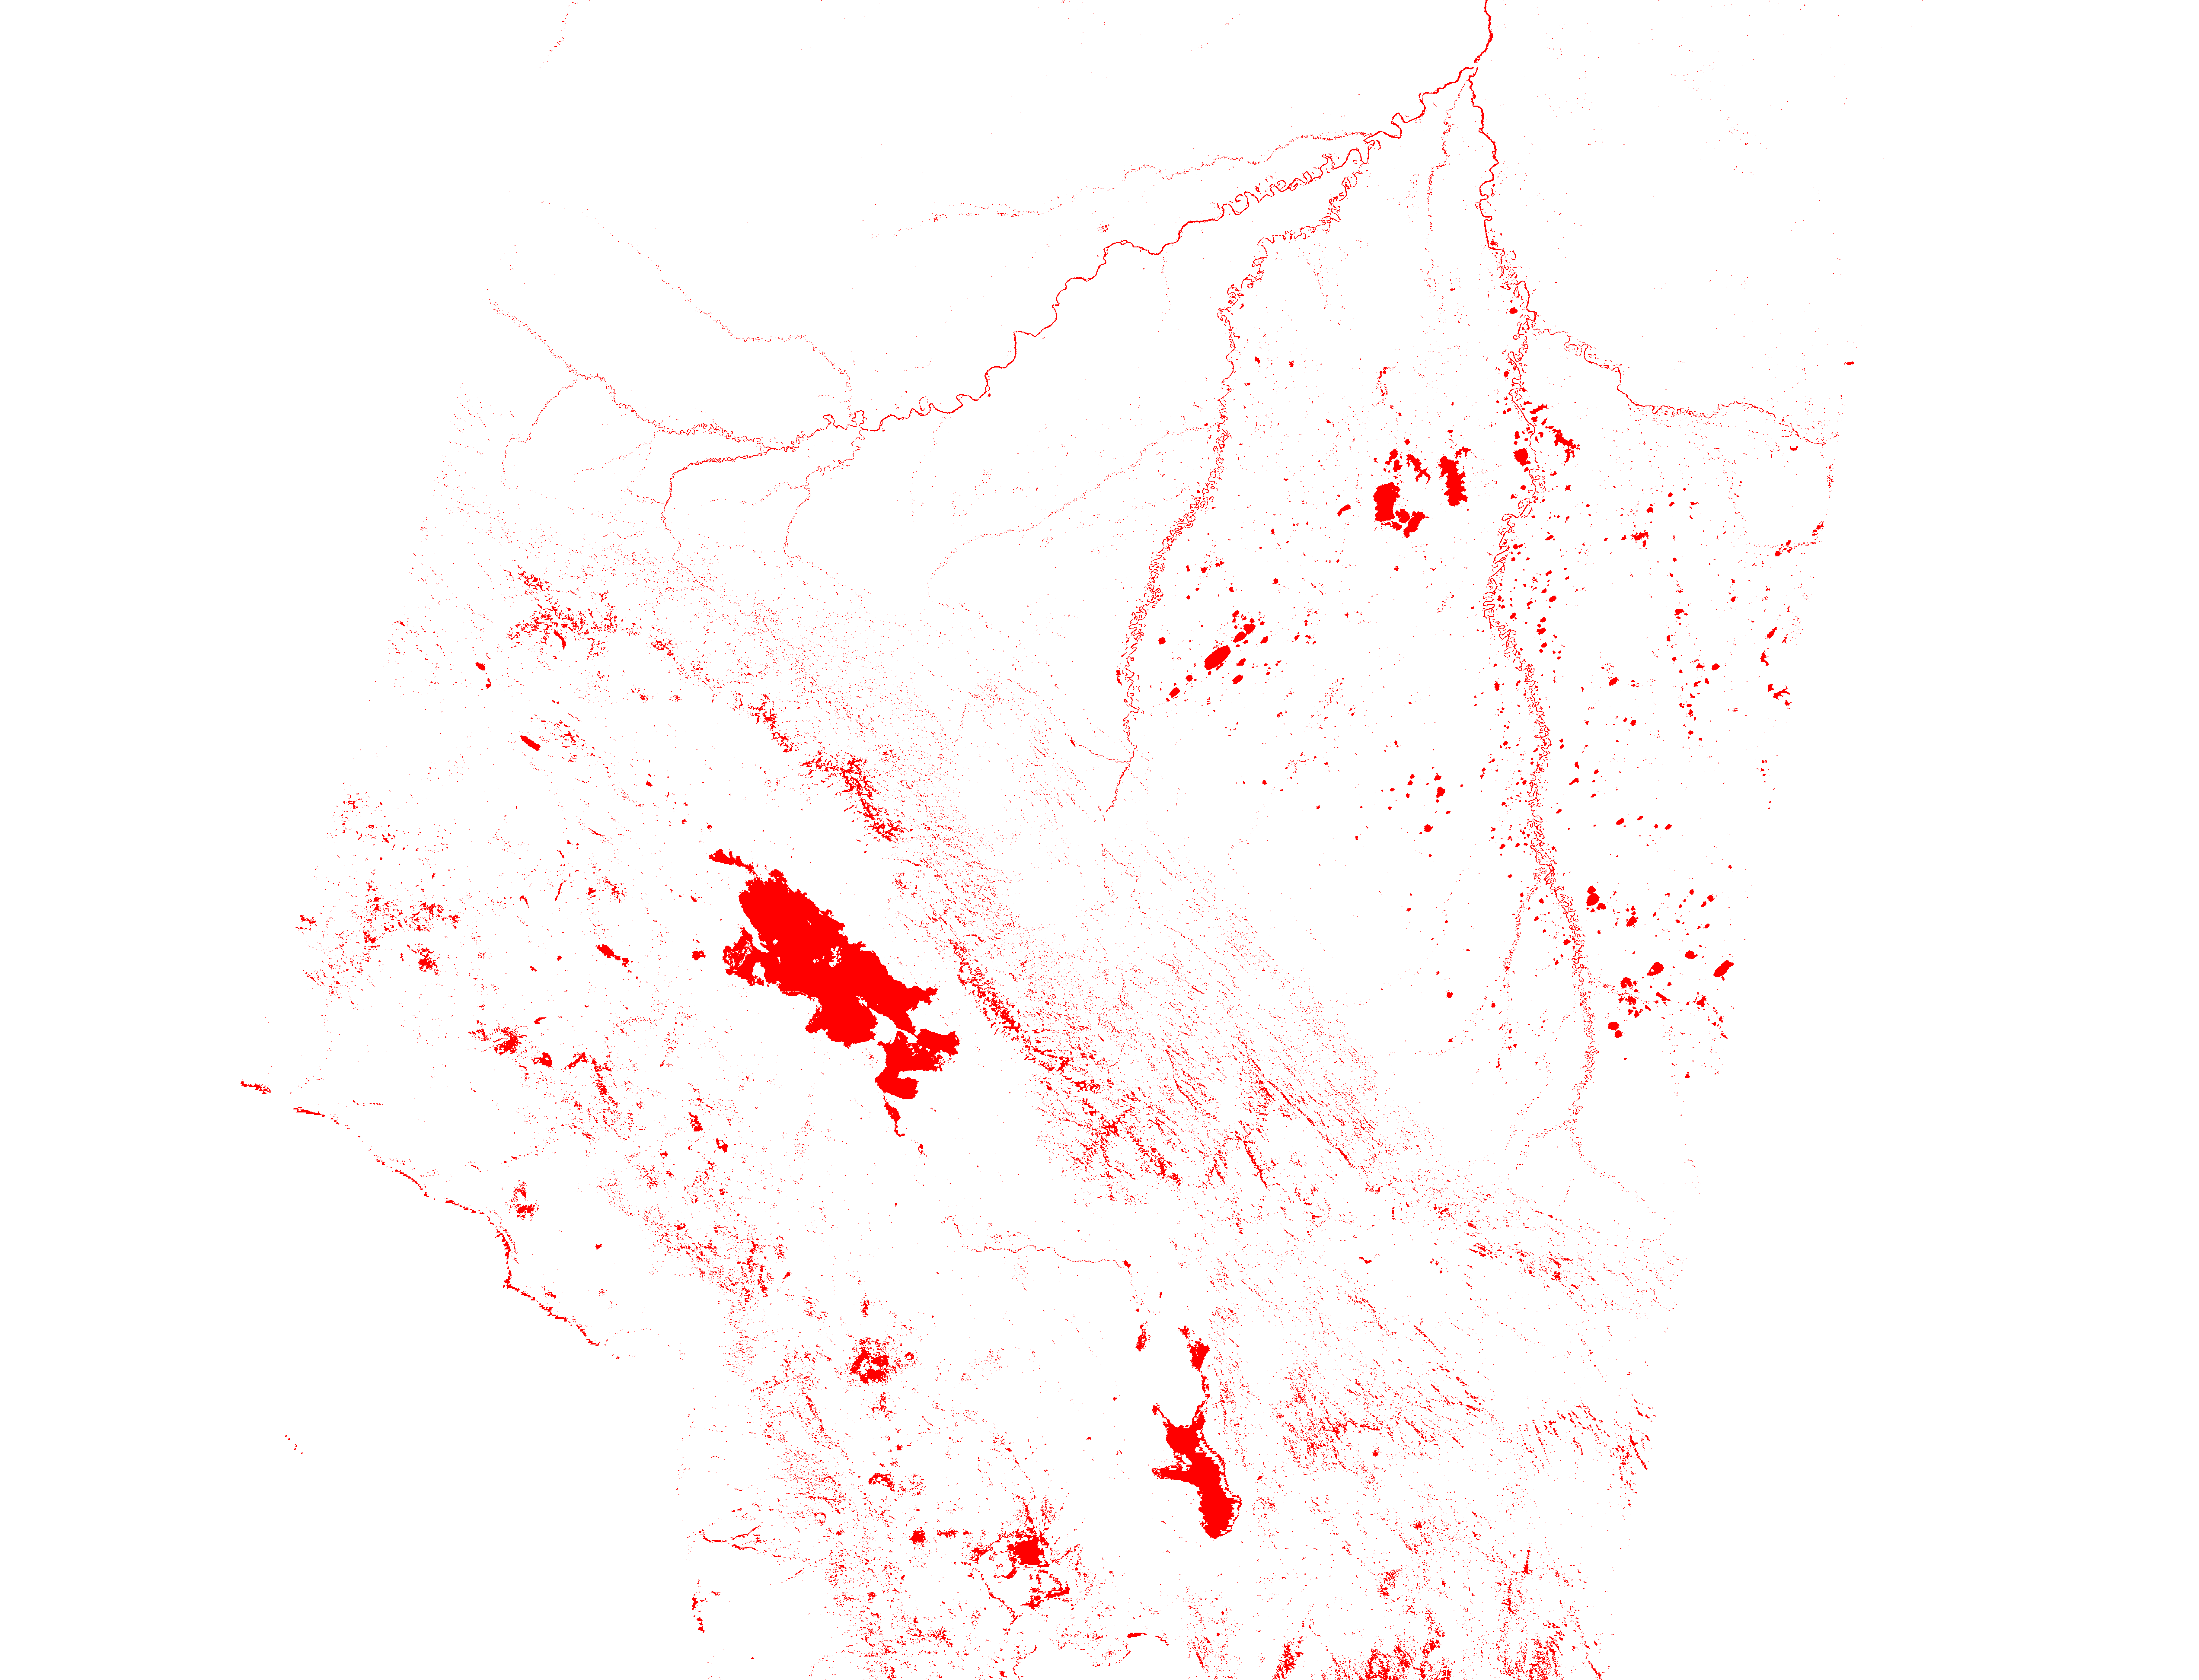
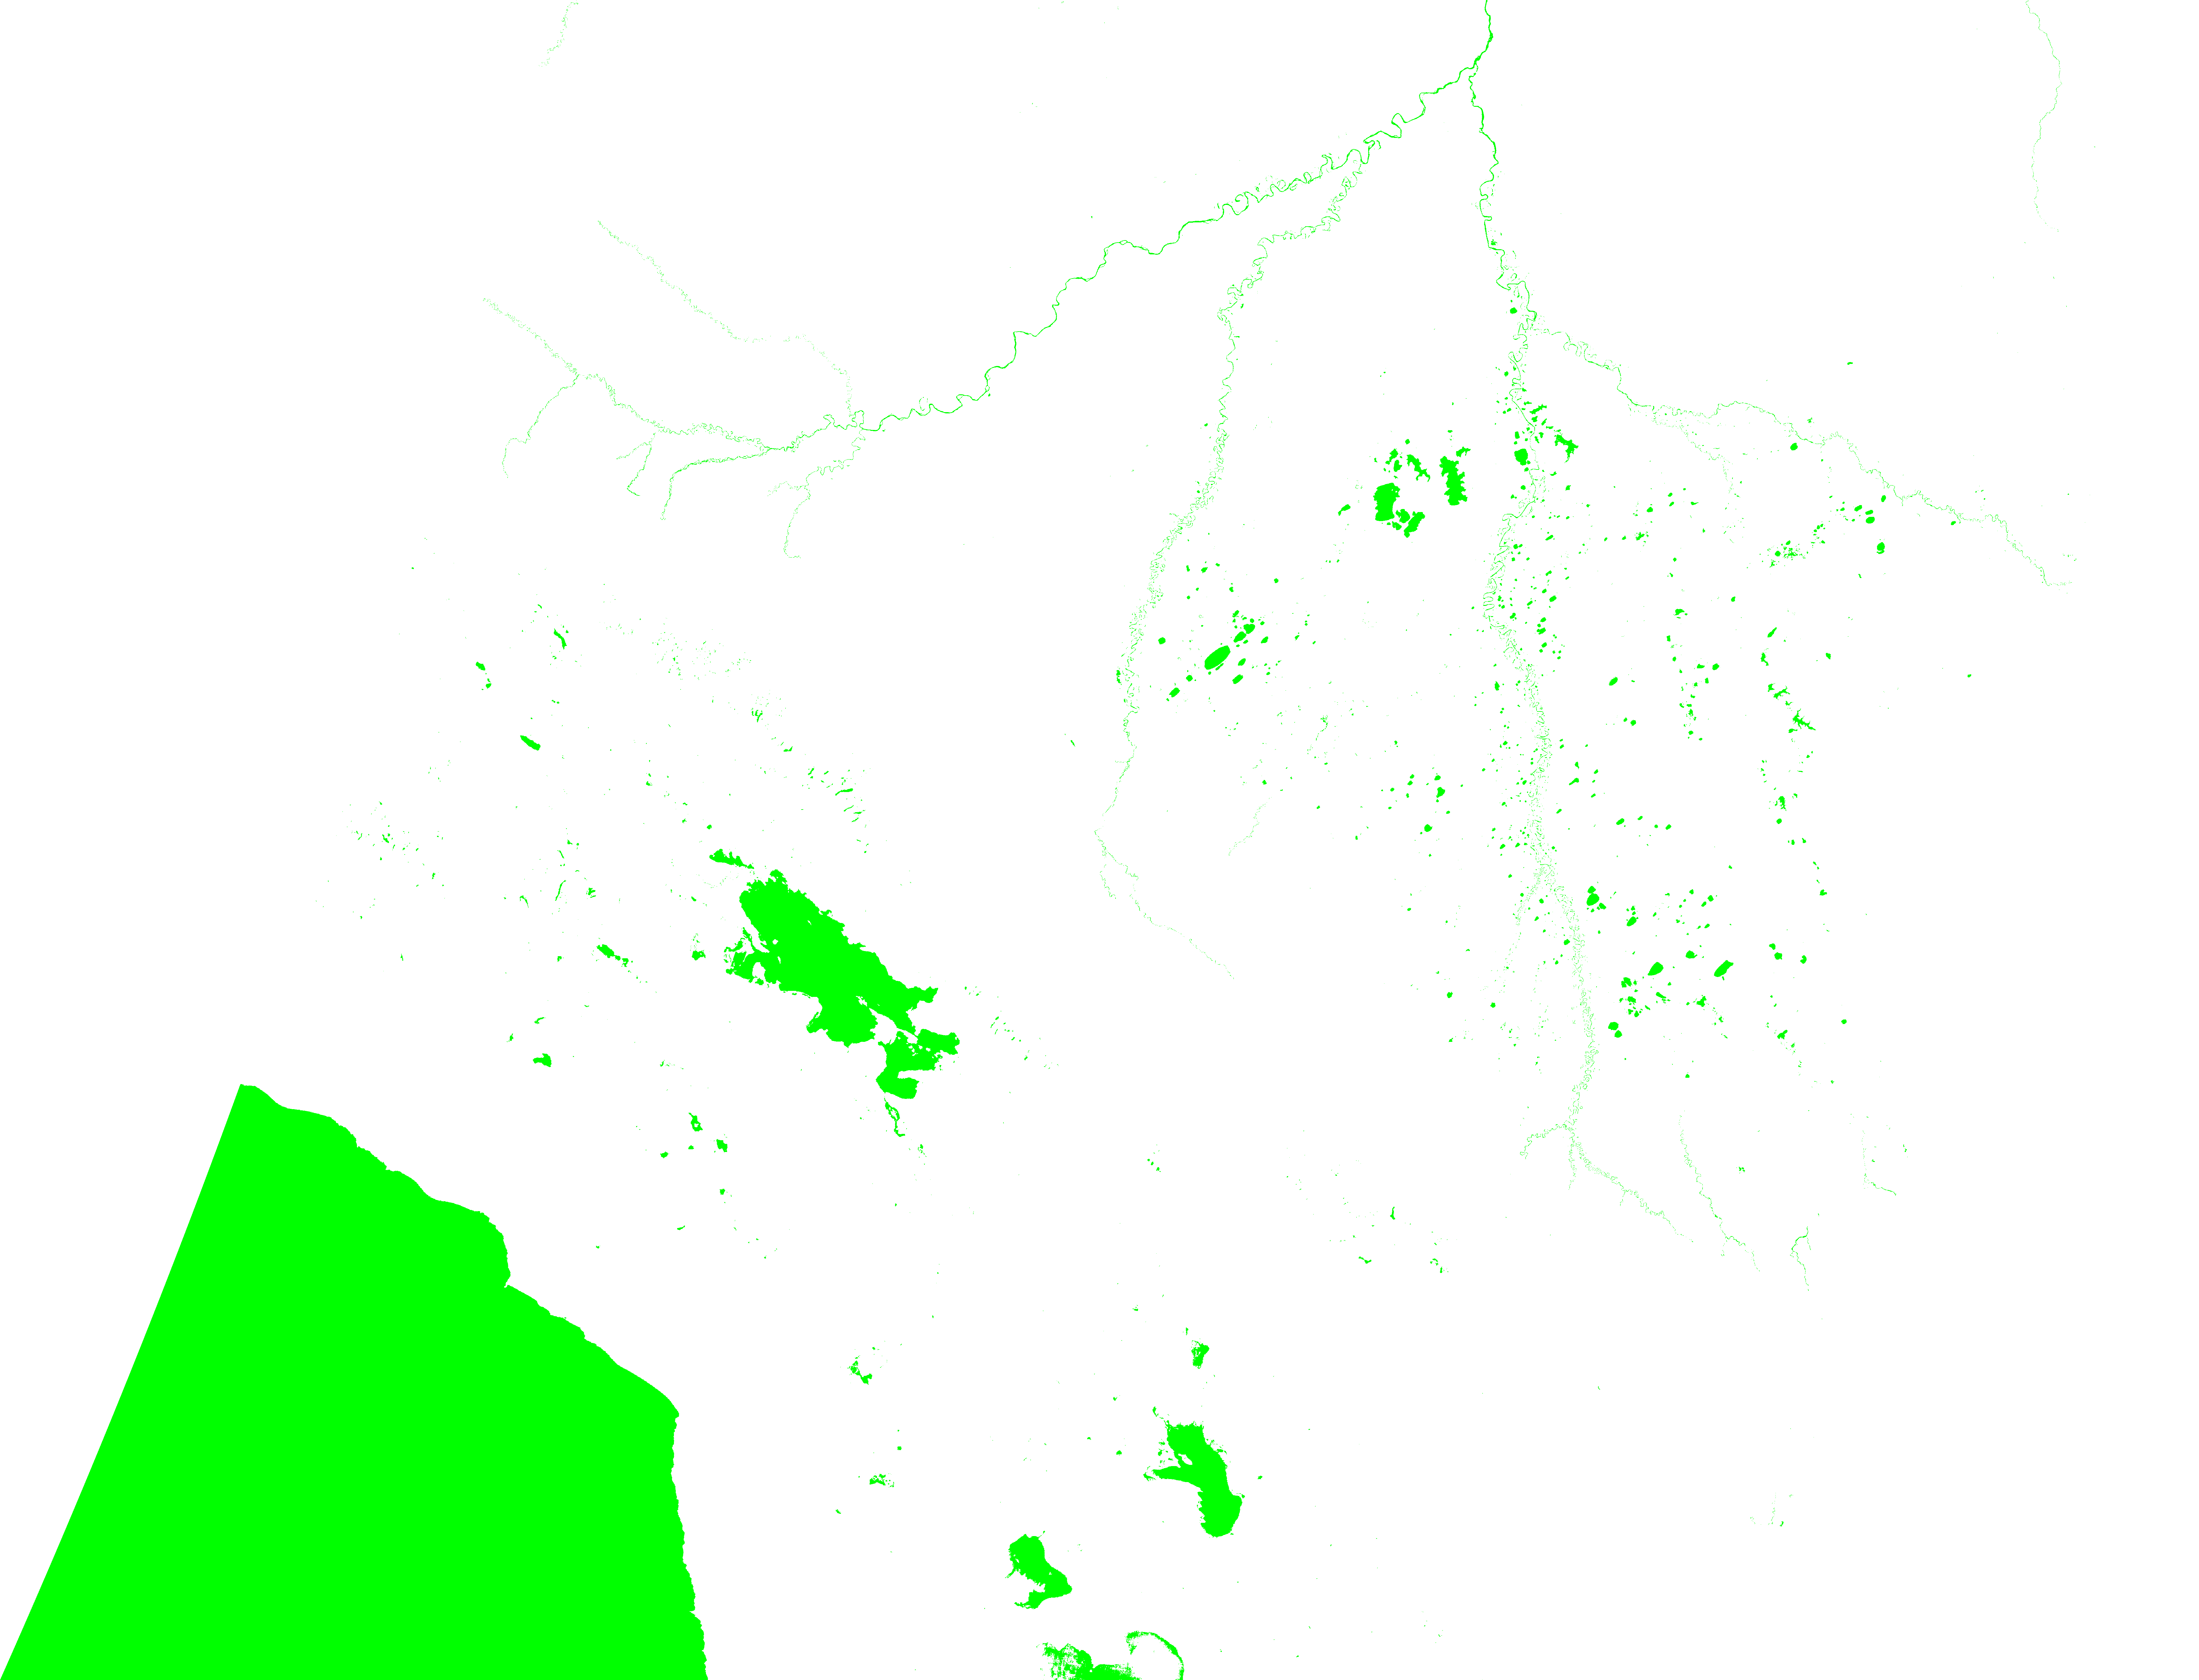
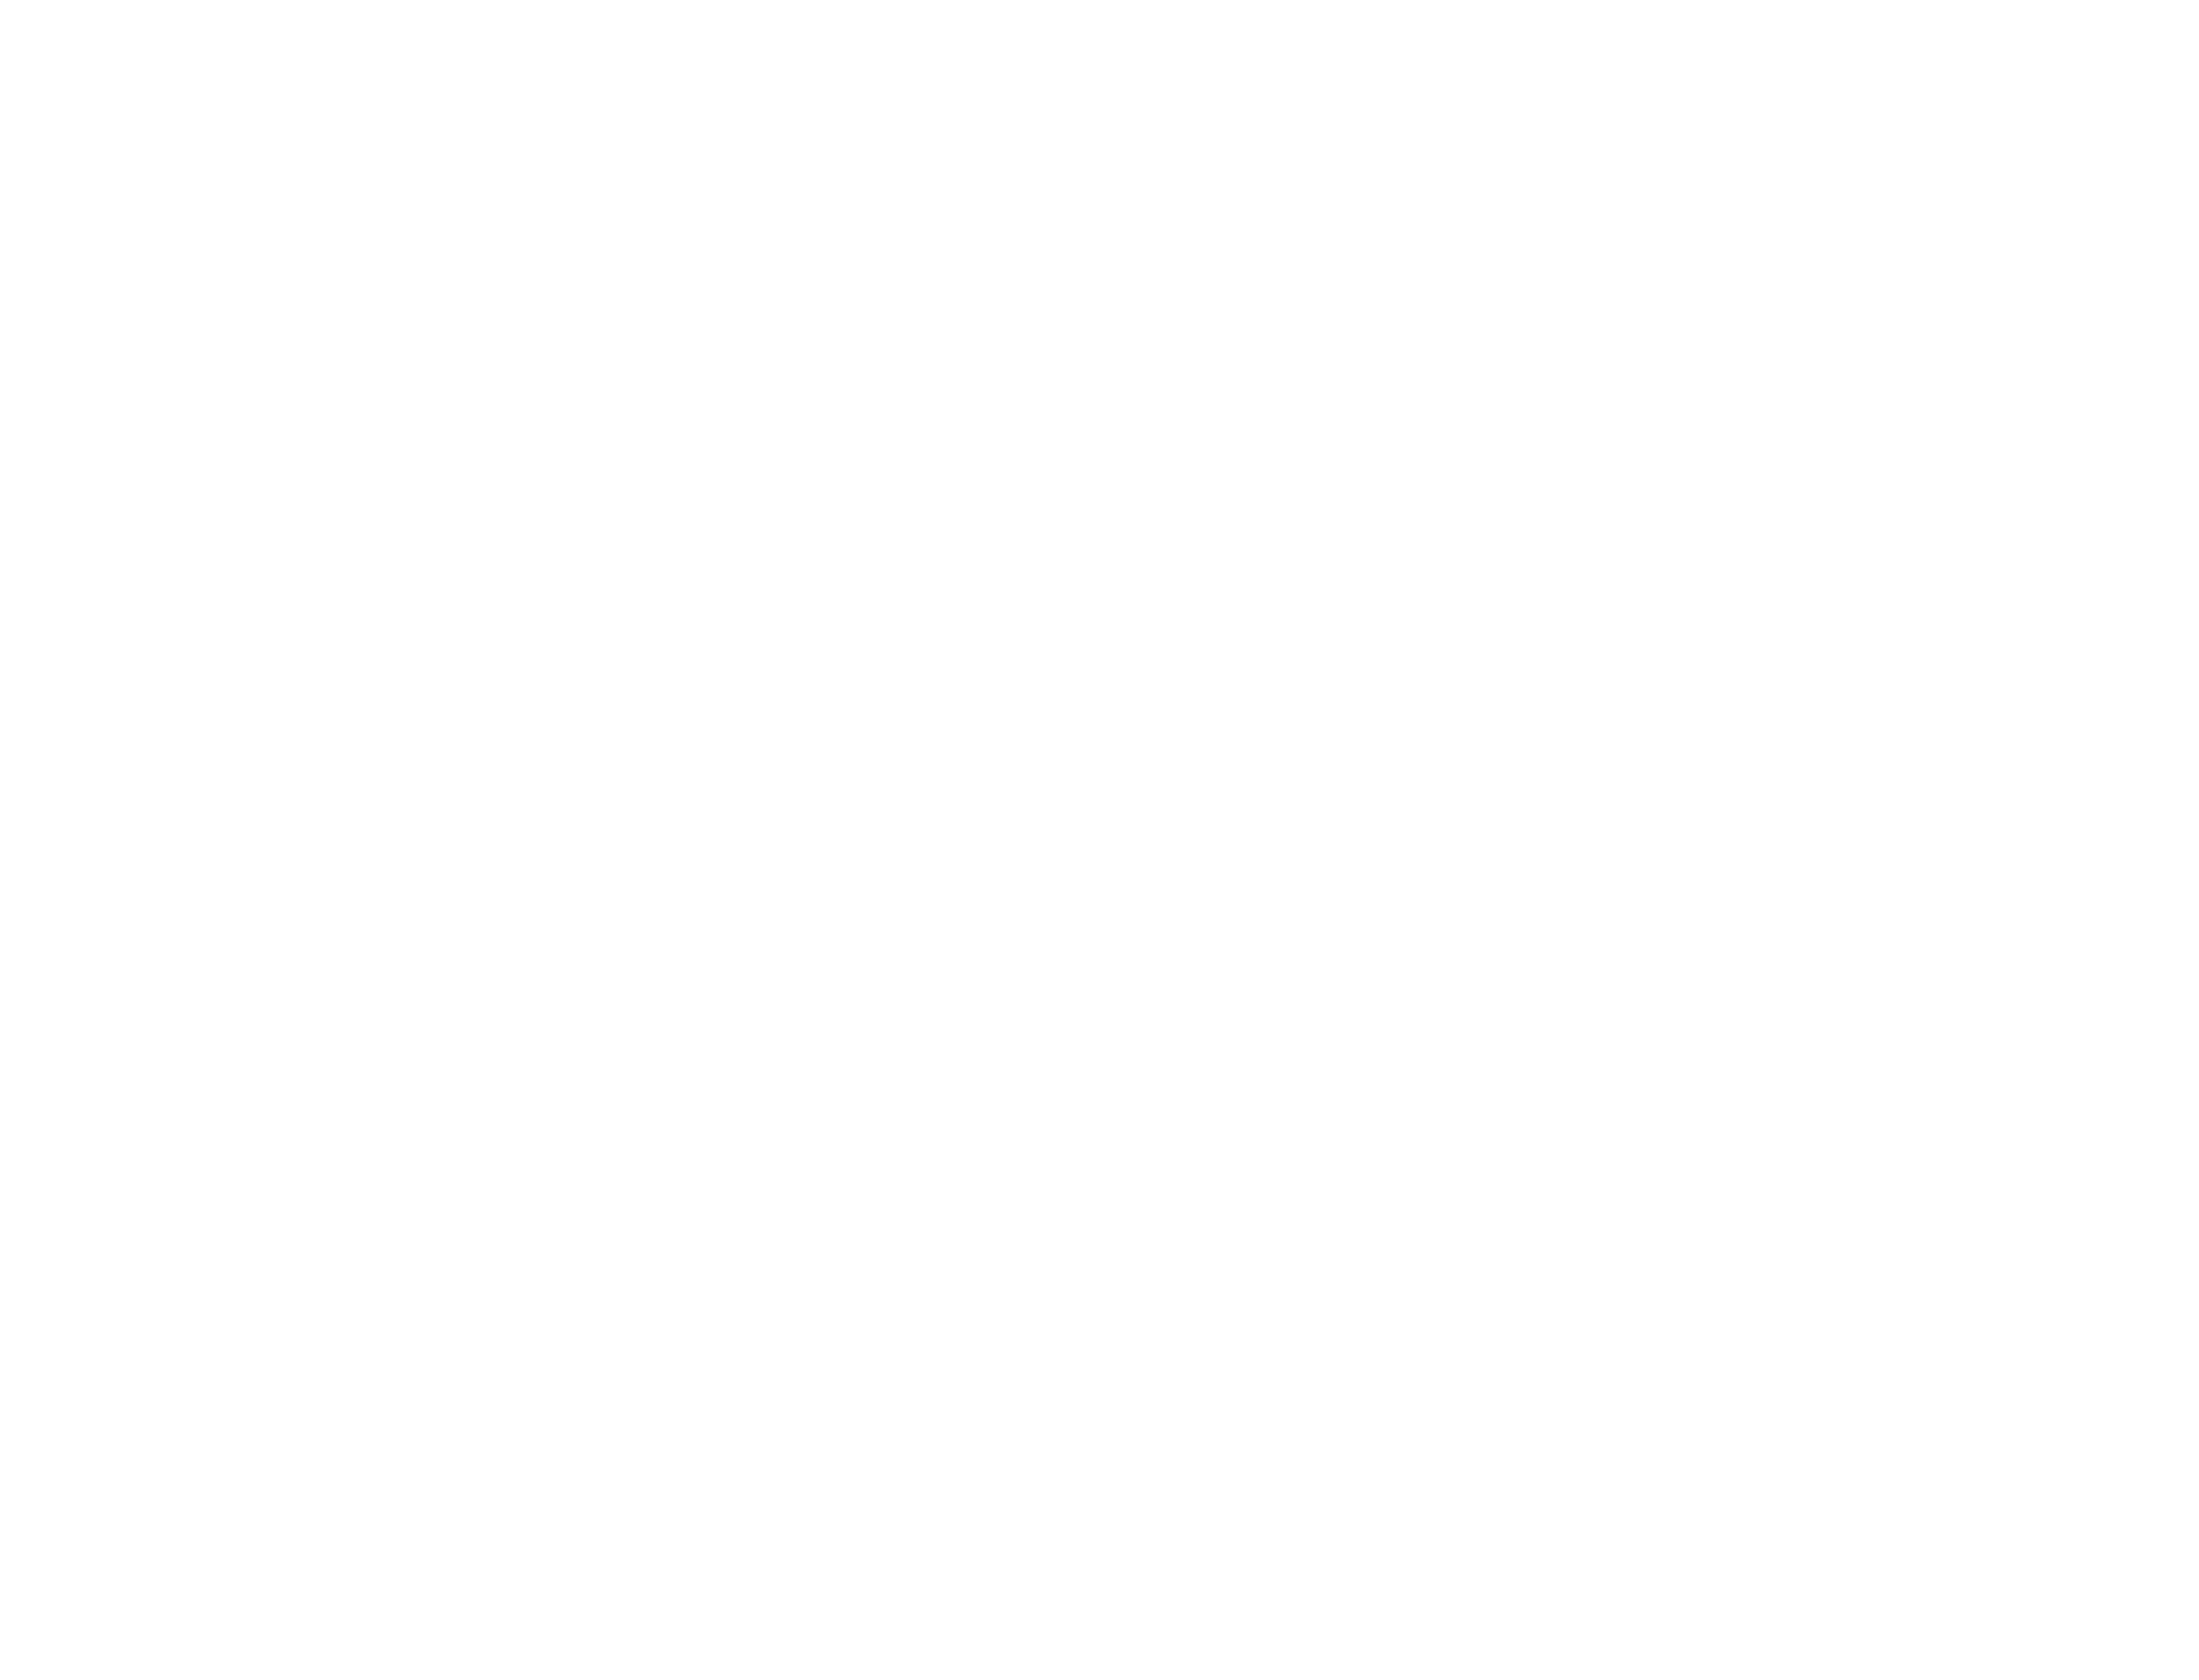

In [70]:
m.add_child(get_overlay(mask_rgba, mask_d, '{}-{}-{} model water mask'.format(YEAR, DAY, TILE), opacity=0.8))
m.add_child(get_overlay(mod44_rgba, mod44_d, '{} {} MOD44W mask'.format(TILE, YEAR), opacity=0.8, show=False))
m.add_child(get_overlay(qa_rgba, qa_d, '{}-{}-{} MW QA mask'.format(YEAR, DAY, TILE), opacity=0.8, show=False))
m.add_child(plugins.MousePosition())
m.add_child(plugins.MeasureControl())
m.add_child(folium.LayerControl())